<a href="https://colab.research.google.com/github/Offliners/writeup/blob/main/HW6/homework6-5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 6 - Generative Adversarial Network**

This is the example code of homework 6 of the machine learning course by Prof. Hung-yi Lee.


In this homework, you are required to build a generative adversarial  network for anime face generation.


## Set up the environment


### Packages Installation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!nvidia-smi

Sat May  8 13:47:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# You may replace the workspace directory if you want.
workspace_dir = './drive/MyDrive/HW6'

# Training progress bar
!pip install -q qqdm
!pip install stylegan2_pytorch

     |████████████████████████████████| 276kB 26.7MB/s 
     |████████████████████████████████| 92kB 12.2MB/s 
     |████████████████████████████████| 163kB 53.1MB/s 
     |████████████████████████████████| 71kB 12.1MB/s 
     |████████████████████████████████| 153kB 56.1MB/s 
     |████████████████████████████████| 61kB 10.8MB/s 
     |████████████████████████████████| 296kB 54.1MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 163kB 56.9MB/s 
     |████████████████████████████████| 71kB 12.3MB/s 
     |████████████████████████████████| 71kB 11.6MB/s 
  Created wheel for vector-quantize-pytorch: filename=vector_quantize_pytorch-0.1.0-cp37-none-any.whl size=2576 sha256=bc13fb04ba9a6bd07739ddefdb753babff677daef2f3ac1a93cdcb0fd96c1a87
  Stored in directory: /root/.cache/pip/wheels/10/68/a9/2eb0d1f485a2babf71ac5e471c9d45703cf2a2cc8686f780d2
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115928 sha256=be466b3c1526da

### Download the dataset
**Please use the link according to the last digit of your student ID first!**

If all download links fail, please follow [here](https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e).

* To open the file using your browser, use the link below (replace the id first!):
https://drive.google.com/file/d/REPLACE_WITH_ID
* e.g. https://drive.google.com/file/d/1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p

In [5]:
!gdown --id 1XpV2G-vOpCH72NU0aWRDToJQf6HbQeBX --output "./crypko_data.zip"
# Other download links
#   Please uncomment the line according to the last digit of your student ID first

# 0
# !gdown --id 131zPaVoi-U--XThvzgRfaxrumc3YSBd3 --output "{workspace_dir}/crypko_data.zip"

# 1
# !gdown --id 1kCuIj1Pf3T2O94H9bUBxjPBKb---WOmH --output "{workspace_dir}/crypko_data.zip"

# 2
# !gdown --id 1boEoiiqBJwoHVvjmI0xgoutE9G0Rv8CD --output "{workspace_dir}/crypko_data.zip"

# 3
# !gdown --id 1Ic0mktAQQvnNAnswrPHsg-u2OWGBXTWF --output "{workspace_dir}/crypko_data.zip"

# 4
# !gdown --id 1PFcc25r9tLE7OyQ-CDadtysNdWizk6Yg --output "{workspace_dir}/crypko_data.zip"

# 5
# !gdown --id 1wgkrYkTrhwDSMdWa5NwpXeE4-7JaUuX2 --output "{workspace_dir}/crypko_data.zip"

# 6
# !gdown --id 19gwNYWi9gN9xVL86jC3v8qqNtrXyq5Bf --output "{workspace_dir}/crypko_data.zip"

# 7 
# !gdown --id 1-KPZB6frRSRLRAtQfafKCVA7em0_NrJG --output "{workspace_dir}/crypko_data.zip"

# 8
# !gdown --id 1rNBfmn0YBzXuG5ub7CXbsGwduZqEs8hx --output "{workspace_dir}/crypko_data.zip"

# 9
# !gdown --id 113NEISX-2j6rBd1yyBx0c3_9nPIzSNz- --output "{workspace_dir}/crypko_data.zip"


Downloading...
From: https://drive.google.com/uc?id=1XpV2G-vOpCH72NU0aWRDToJQf6HbQeBX
To: /content/crypko_data.zip
452MB [00:05, 79.5MB/s]


###Unzip the downloaded file.
The unzipped tree structure is like 
```
faces/
├── 1.jpg
├── 2.jpg
├── 3.jpg
...
```

In [6]:
!unzip -q "./crypko_data.zip" -d "./"

## Random seed
Set the random seed to a certain value for reproducibility.

In [7]:
import random

import torch
import numpy as np


def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(0)

## Import Packages
First, we need to import packages that will be used later.

Like hw3, we highly rely on **torchvision**, a library of PyTorch.

In [8]:
import os
import glob

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from qqdm.notebook import qqdm

# For SNGAN
from torch.nn.utils import spectral_norm

## Dataset
1. Resize the images to (64, 64)
1. Linearly map the values from [0, 1] to  [-1, 1].

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.


In [9]:
class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        # 1. Load the image
        img = torchvision.io.read_image(fname)
        # 2. Resize and normalize the images using torchvision.
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples


def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    # 1. Resize the image to (64, 64)
    # 2. Linearly map [0, 1] to [-1, 1]
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset

### Show some images
Note that the values are in the range of [-1, 1], we should shift them to the valid range, [0, 1], to display correctly.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


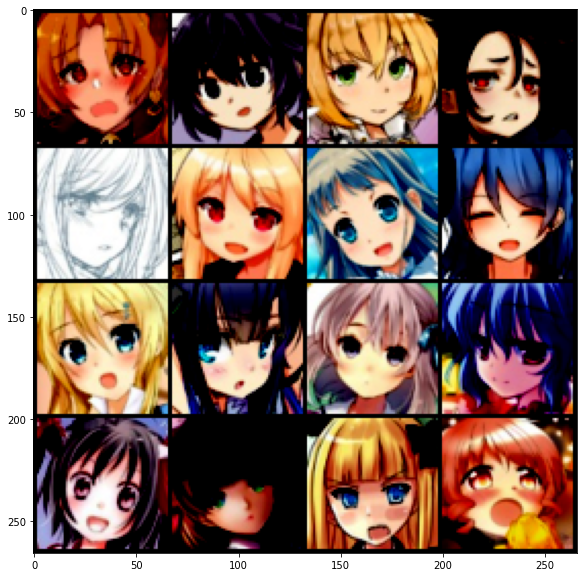

In [10]:
dataset = get_dataset(os.path.join('.', 'faces'))

images = [dataset[i] for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

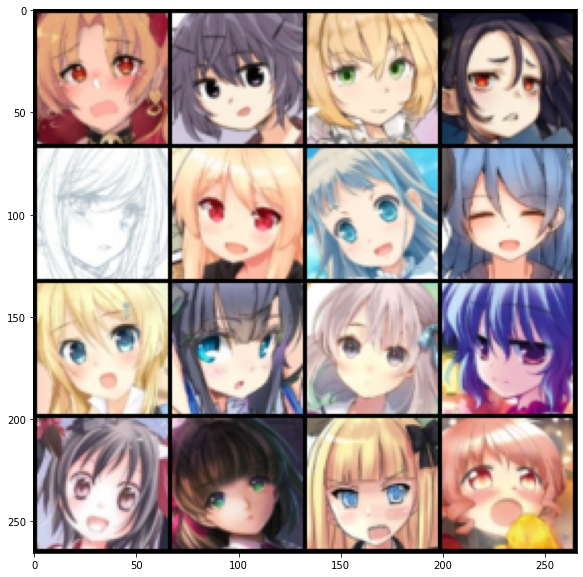

In [11]:
images = [(dataset[i]+1)/2 for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

## Model
Here, we use a simple CNN-based model structure. Feel free to modify your own model structure.

Note that the `N` of the input/output shape stands for the batch size.

## Training

In [ ]:
!stylegan2_pytorch --data faces --results_dir ./drive/MyDrive/HW6/stylegan/result --models_dir ./drive/MyDrive/HW6/stylegan/checkpoints --network-capacity 256 --num-train-steps 100000 --image-size 64

continuing from previous epoch - 2
loading from version 1.8.1
default<faces>:   2% 2000/100000 [00:00<?, ?it/s]G: -85.11 | D: 1.28 | GP: 1.90
default<faces>:   2% 2048/100000 [03:50<129:11:45,  4.75s/it]G: 2.00 | D: 1.19 | GP: 41.20
default<faces>:   2% 2099/100000 [08:10<131:42:53,  4.84s/it]G: 6.73 | D: 11.85 | GP: 23.21
default<faces>:   2% 2149/100000 [11:59<136:51:55,  5.04s/it]G: -7.84 | D: 14.04 | GP: 30.20
default<faces>:   2% 2200/100000 [16:01<128:21:17,  4.72s/it]G: 8.26 | D: 2.08 | GP: 0.97
default<faces>:   2% 2248/100000 [19:53<128:43:06,  4.74s/it]G: 2.82 | D: 1.37 | GP: 0.78
default<faces>:   2% 2299/100000 [24:10<131:02:46,  4.83s/it]G: -31.26 | D: 38.24 | GP: 22.95
default<faces>:   2% 2349/100000 [28:03<136:35:22,  5.04s/it]G: 7.79 | D: 2.60 | GP: 0.18
default<faces>:   2% 2400/100000 [32:06<128:54:19,  4.75s/it]G: -0.16 | D: 1.69 | GP: 1.64
default<faces>:   2% 2450/100000 [36:11<135:25:25,  5.00s/it]G: 0.39 | D: 1.87 | GP: 0.10
default<faces>:   2% 2499/100000 [40:

### Initialization
- hyperparameters
- model
- optimizer
- dataloader

### Training loop
We store some pictures regularly to monitor the current performance of the Generator, and regularly record checkpoints.

## Inference
Use the trained model to generate anime faces!

### Load model 

In [32]:
import torch

G = Generator()
checkpoint_G = torch.load(os.path.join(ckpt_dir, 'G_100.pth'))
G.load_state_dict(checkpoint_G['model_state_dict'])

G.eval()
G.cuda()

Generator(
  (l4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (l1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (l2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (l3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (last): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
  )
  (attn1): Self_At

### Generate and show some images.


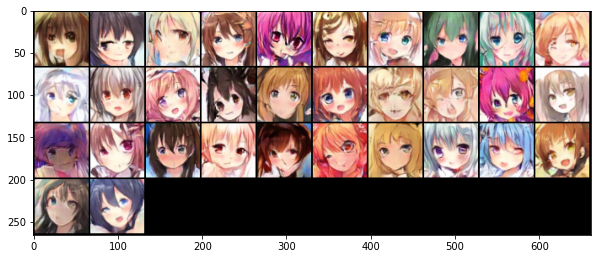

In [33]:
# Generate 1000 images and make a grid to save them.
n_output = 1000
z_sample = Variable(torch.randn(n_output, z_dim)).cuda()
imgs_sample = (G(z_sample).data + 1) / 2.0
log_dir = os.path.join(workspace_dir, 'logs')
filename = os.path.join(log_dir, 'result.jpg')
torchvision.utils.save_image(imgs_sample, filename, nrow=10)

# Show 32 of the images.
grid_img = torchvision.utils.make_grid(imgs_sample[:32].cpu(), nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### Compress the generated images using **tar**.


In [ ]:
# Save the generated images.
os.makedirs('output', exist_ok=True)
for i in range(1000):
    torchvision.utils.save_image(imgs_sample[i], f'output/{i+1}.jpg')
  
# Compress the images.
%cd output
!tar -zcf ../images.tgz *.jpg
%cd ..

from google.colab import files
files.download("images.tgz")